In [63]:
import nltk
# import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time



In [64]:
import pandas as pd

In [4]:
nltk.download('vader_lexicon')

[nltk_data] Error loading vader_lexicon: <urlopen error [WinError
[nltk_data]     10060] A connection attempt failed because the
[nltk_data]     connected party did not properly respond after a
[nltk_data]     period of time, or established connection failed
[nltk_data]     because connected host has failed to respond>


False

VADER (Valence Aware Dictionary and sEntiment Reasoner):

VADER is a lexicon and rule-based sentiment analysis tool specifically designed for social media text. It assigns polarity scores to individual words and uses grammatical rules to determine the sentiment of a text based on the overall polarity of its constituent words. VADER is particularly effective at capturing sentiment in short, informal text like tweets.

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm



In [6]:
sia = SentimentIntensityAnalyzer()

In [7]:
df = pd.read_csv(r'C:\Projects\web helpers\archive\Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [90]:
def label(row):
    if row['Score'] > 3:
        return 'positive'
   
    else:
        return 'negative'

df['label'] = df.apply(label, axis=1)

In [91]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,label
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [ ]:
df.to_csv('sentiments.csv', index=False)

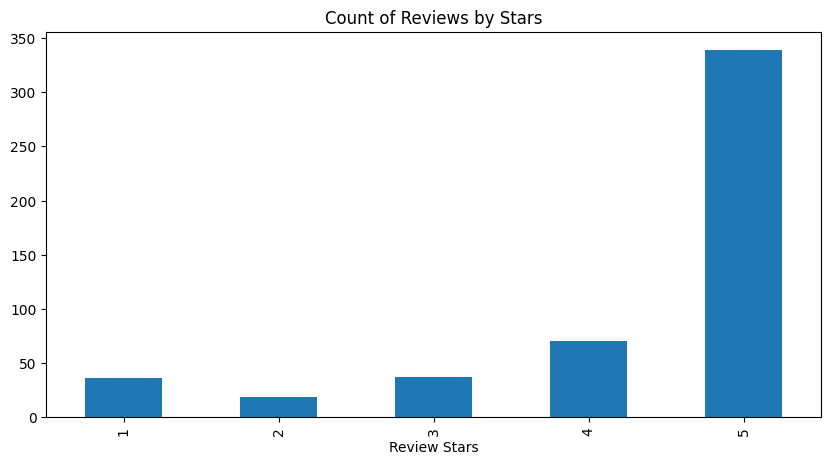

In [8]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [68]:
vader_computation_times = []
roberta_computation_times = []
textblob_computation_times = []

In [69]:
res = {}
vader_start_time = time.time()
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)
vader_end_time = time.time()

vader_computation_times.append(vader_end_time - vader_start_time)

  0%|          | 0/500 [00:00<?, ?it/s]

In [92]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [93]:
def get_dominant_sentiment(row):
    if row['vader_compound'] > 0.05:
        return 'positive'
    elif row['vader_compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

vaders['dominant_sentiment'] = vaders.apply(get_dominant_sentiment, axis=1)

# vader model scores

In [77]:
# Now we have sentiment score and metadata
vaders.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,dominant_sentiment
0,1,0.000,0.711,0.289,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,0.085,0.771,0.144,0.8138,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,0.000,0.932,0.068,0.4404,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,positive
4,5,0.000,0.599,0.401,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [106]:
true_labels = df['label'].tolist()
print(true_labels)
predicted_labels = vaders['dominant_sentiment'].tolist()
print(predicted_labels)

# true_labels = true_labels.reset_index(drop=True)
# predicted_labels = predicted_labels.reset_index(drop=True)

correct_predictions =  sum(true_label == predicted_label for true_label, predicted_label in zip(true_labels, predicted_labels))
total_samples = len(true_labels)
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy:.2f}")

['positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'ne

In [86]:
vaders.to_csv('sentiment.csv', index=False)

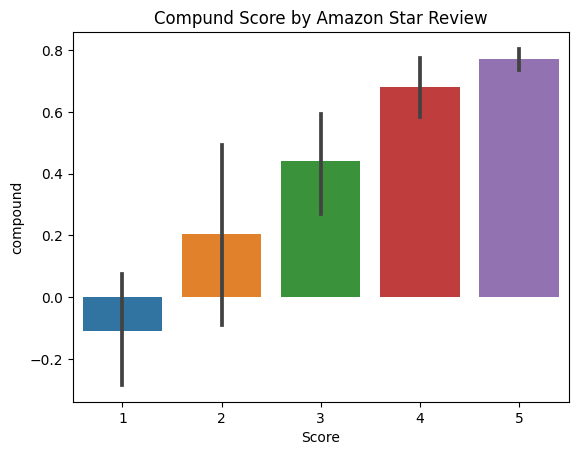

In [20]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

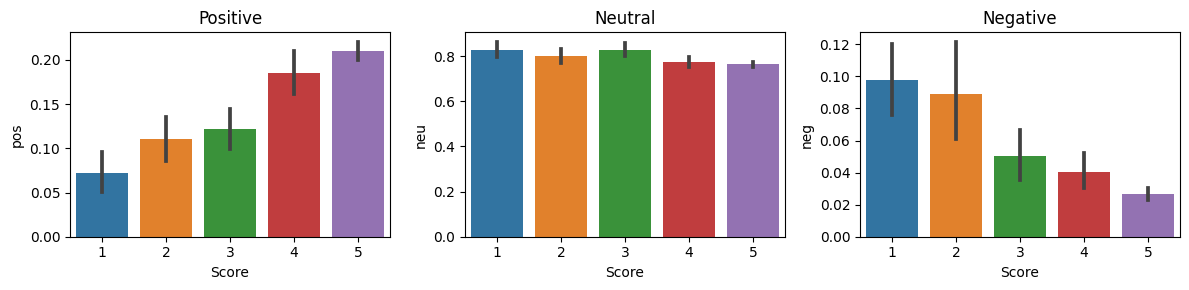

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

RoBERTa (A Robustly Optimized BERT Pretraining Approach):

RoBERTa is a state-of-the-art transformer-based language model designed for various natural language processing tasks, including sentiment analysis. It is pretrained on a large corpus of text and fine-tuned on specific tasks. RoBERTa captures contextual information and relationships between words, enabling it to understand more nuanced sentiments and dependencies in text.

In [28]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [30]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [31]:
example = df['Text'][50]

In [32]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.02068747, 'roberta_pos': 0.0029573706}


In [33]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [109]:
res = {}
roberta_start_time = time.time()
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        
        roberta_result = polarity_scores_roberta(text)
        both = {**roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')
roberta_end_time = time.time()
roberta_computation_times.append(roberta_end_time - roberta_start_time)

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


# Roberta model scores

In [110]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [111]:
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,label
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [112]:
def get_sentiment_label(row):
    max_score = max(row['roberta_neg'], row['roberta_pos'], row['roberta_neu'])
    
    if max_score == row['roberta_neg']:
        return 'negative'
    elif max_score == row['roberta_pos']:
        return 'positive'
    else:
        return 'neutral'

# Apply the function to create a new 'Sentiment_Label' column
results_df['Sentiment_Label'] = results_df.apply(get_sentiment_label, axis=1)

In [115]:
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,label,Sentiment_Label
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,positive
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative,negative
2,3,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive,positive
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative,positive
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive,positive


In [117]:
true_labels = df['label'].tolist()
print(true_labels)
predicted_labels = results_df['Sentiment_Label'].tolist()
print(predicted_labels)

# true_labels = true_labels.reset_index(drop=True)
# predicted_labels = predicted_labels.reset_index(drop=True)

correct_predictions =  sum(true_label == predicted_label for true_label, predicted_label in zip(true_labels, predicted_labels))
total_samples = len(true_labels)
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy:.2f}")

['positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'ne

In [36]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Comparison of scores

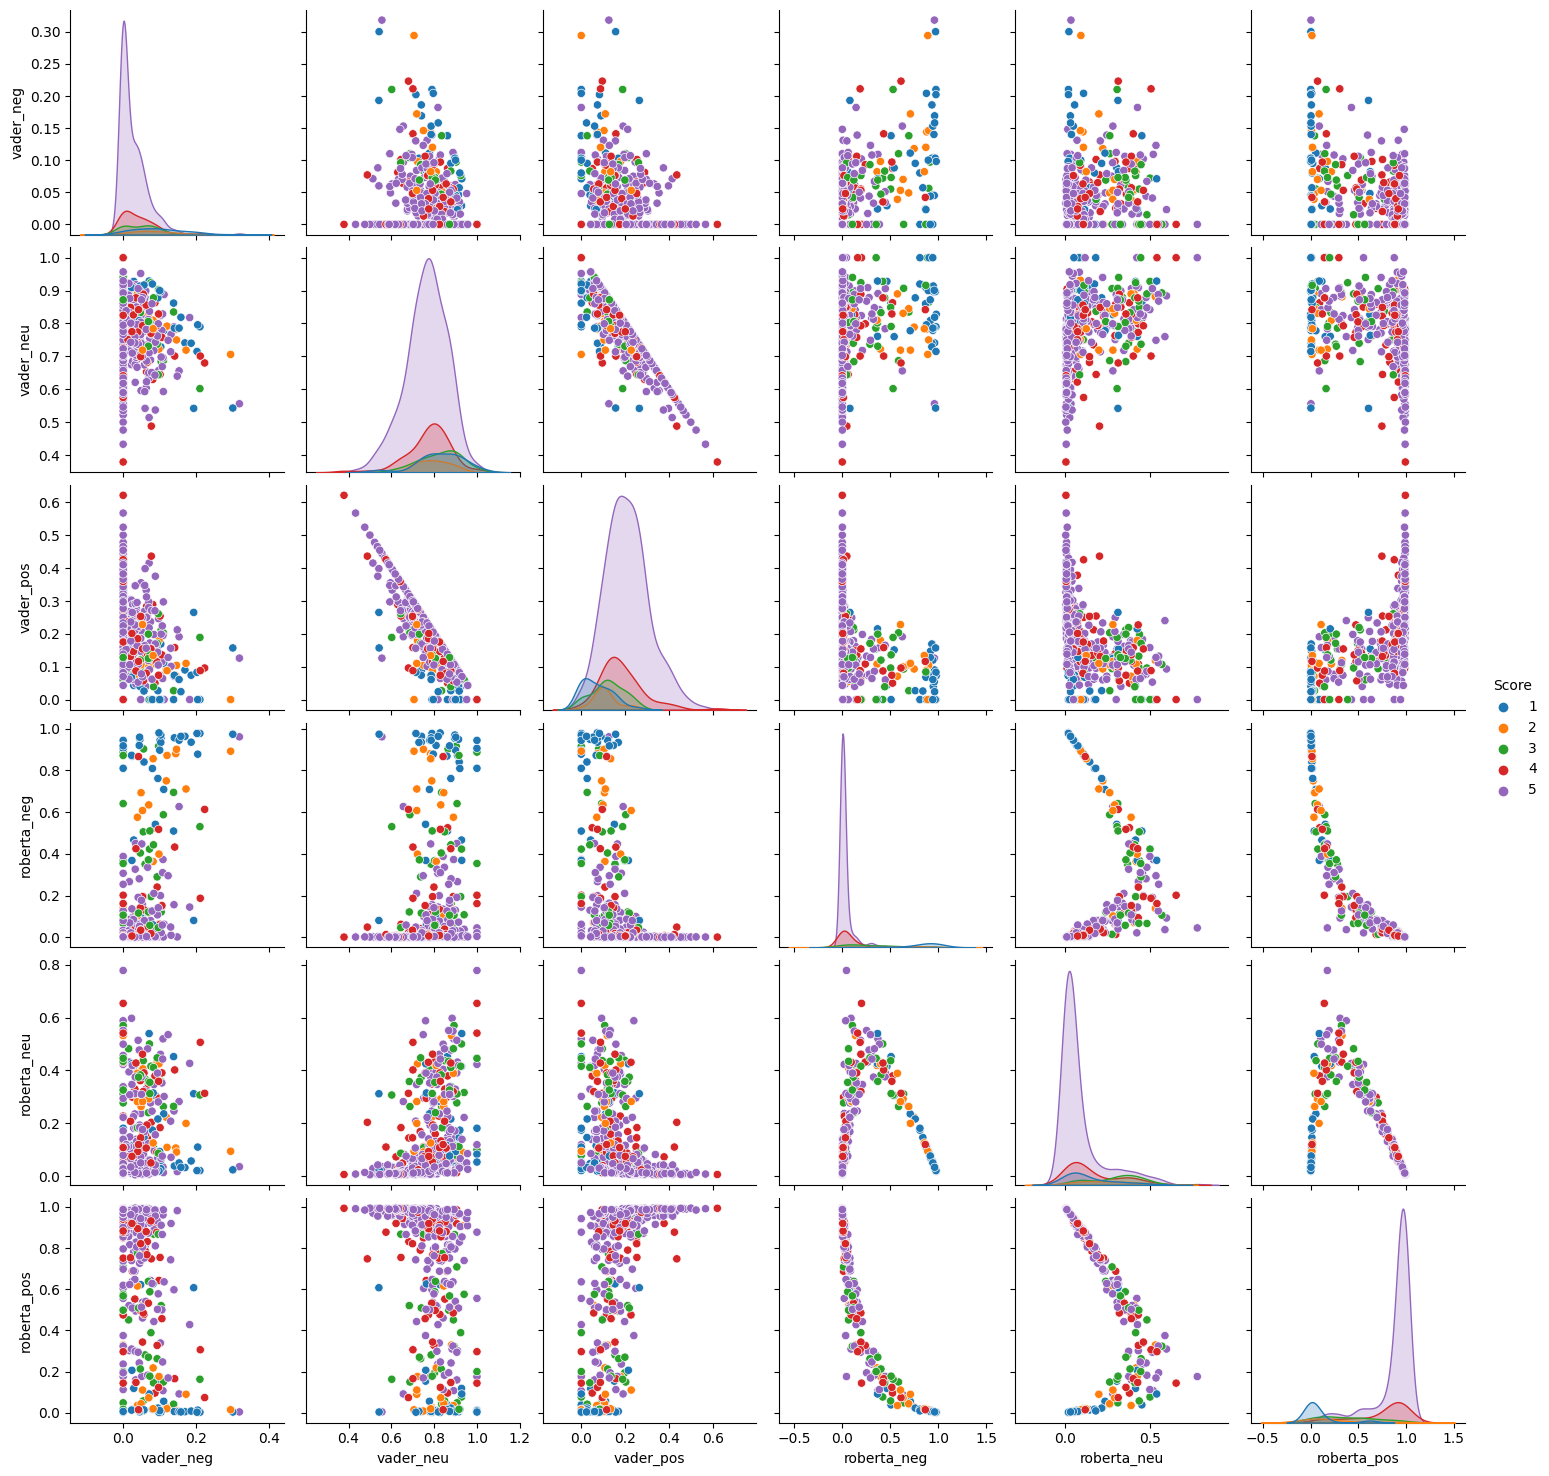

In [37]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

TextBlob:

TextBlob is a simple natural language processing library that provides an easy-to-use interface for various NLP tasks, including sentiment analysis. It uses a pre-trained sentiment polarity model to classify text as positive, negative, or neutral based on the sentiment scores of individual words.

In [39]:
from textblob import TextBlob

In [43]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [45]:
amazon_reviews = df['Text'].tolist()

In [78]:
textblob_start_time = time.time()
sentiment_scores = [analyze_sentiment(review) for review in amazon_reviews]
textblob_end_time = time.time()
textblob_computation_times.append(textblob_end_time - textblob_start_time)

In [79]:
print(sentiment_scores)

[0.45, -0.033333333333333326, 0.1335714285714286, 0.16666666666666666, 0.48333333333333334, 0.25740740740740736, 0.25083333333333335, 0.48600000000000004, 0.42857142857142855, 0.44999999999999996, 0.20859375, 0.012500000000000002, 0.12992424242424241, 0.64, -0.5, 0.225, 0.50625, 0.4125, 0.1284722222222222, 0.24, 0.4, 0.11666666666666665, 0.125, 0.25, 0.3214285714285714, 0.0, 0.0, 0.14583333333333331, 0.38636363636363635, 0.20859375, 0.2557692307692308, 0.6, 0.2205, 0.3661538461538462, 0.29333333333333333, 0.2261904761904762, 0.19791666666666669, 0.045138888888888895, 0.159375, 0.2, 0.23194444444444443, 0.0674769071508202, 0.6875, 0.63, 0.4666666666666666, 0.1708333333333333, 0.475, 0.7, 0.3547619047619048, 0.05, -0.12499999999999999, 0.3625, -0.1257638888888889, 0.05222222222222221, 0.17247474747474748, 0.41825396825396827, 0.13888888888888887, 0.625, 0.7875, 0.43333333333333335, 0.26666666666666666, 0.16499999999999998, -0.78125, 0.3291666666666666, 0.03690476190476192, 0.149074074074

In [55]:
sentiment_labels = ['negative' if score < 0 else 'neutral' if score == 0 else 'positive' for score in sentiment_scores]

In [122]:
frame = {
    'scores' : sentiment_scores,
    'sentiment_labels' : sentiment_labels,
    'label' : labels
    
    }

# Textblob model scores

In [123]:
file = pd.DataFrame(frame)

In [121]:
labels = df['label'].tolist()

In [124]:
file.head()

,scores,sentiment_labels,label
0,0.450000,positive,positive
1,-0.033333,negative,negative
2,0.133571,positive,positive
3,0.166667,positive,negative
4,0.483333,positive,positive


In [125]:
true_labels = file['label'].tolist()
print(true_labels)
predicted_labels = file['sentiment_labels'].tolist()
print(predicted_labels)

# true_labels = true_labels.reset_index(drop=True)
# predicted_labels = predicted_labels.reset_index(drop=True)

correct_predictions =  sum(true_label == predicted_label for true_label, predicted_label in zip(true_labels, predicted_labels))
total_samples = len(true_labels)
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy:.2f}")

['positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'ne

In [56]:
from collections import Counter
sentiment_counts = Counter(sentiment_labels)

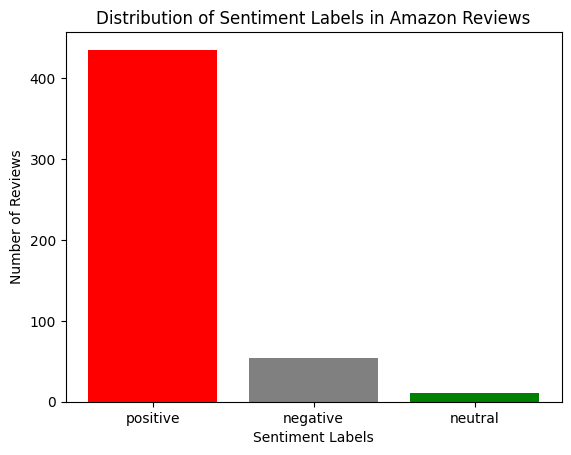

In [57]:
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['red', 'gray', 'green'])

# Set axis labels and title
plt.xlabel('Sentiment Labels')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment Labels in Amazon Reviews')

# Show the plot
plt.show()






In [80]:
average_vader_computation_time = sum(vader_computation_times) / len(vader_computation_times)
average_roberta_computation_time = sum(roberta_computation_times) / len(roberta_computation_times)
average_textblob_computation_time = sum(textblob_computation_times) / len(textblob_computation_times)

In [81]:
print(f"Average Computation Time (VADER): {average_vader_computation_time:.4f} seconds")
print(f"Average Computation Time (RoBERTa): {average_roberta_computation_time:.4f} seconds")
print(f"Average Computation Time (TextBlob): {average_textblob_computation_time:.4f} seconds")

Average Computation Time (VADER): 0.3950 seconds
Average Computation Time (RoBERTa): 102.9384 seconds
Average Computation Time (TextBlob): 0.2438 seconds


 Recommendation for Production Deployment:
 
Given the nature of the task—sentiment analysis of product reviews—and the evaluation results, I recommend deploying the Vader model in production for sentiment analysis. Vader demonstrates superior performance in capturing nuanced sentiments, which is essential for analyzing diverse and rich product reviews. It also has good computational time, its accuracy and ability to understand context make it a valuable choice for accurate sentiment analysis, providing meaningful insights into customer sentiments and feedback.

By deploying the Vader model, you can ensure that your sentiment analysis system delivers high-quality results and helps you make informed business decisions based on accurate understanding of customer sentiments.